### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Simulate data

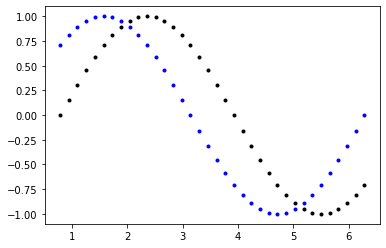

In [2]:
time = np.linspace(0, 2*np.pi, 40+1)
data = np.sin(time)

time_diff = 5

xtr = data[:-time_diff].reshape(len(data)-time_diff, 1)
ytr = data[time_diff:].reshape(len(data)-time_diff, 1)
t = time[time_diff:]

plt.plot(t,xtr, 'k.', t,ytr,'b.')
plt.show()

### Model

In [3]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(SimpleRNN, self).__init__()
        
        self.hidden_dim = hidden_dim
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
        
        self.fc = nn.Linear(hidden_dim, output_size)
        
    def forward(self, x, hidden):
        x, hidden = self.rnn(x, hidden)
        x = x.view(-1, self.hidden_dim)
        out = self.fc(x)
        return out, hidden

In [4]:
# Instantiate the model
rnn_model = SimpleRNN(input_size=1, output_size=1, hidden_dim=32, n_layers=2)
print(rnn_model)

SimpleRNN(
  (rnn): RNN(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [5]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.01)

### Train model

In [6]:
def train(rnn_model, xtr, ytr, n_steps):
    
    hidden = None # initialize the hidden state
    
    for ibatch in range(n_steps):
        
        xbatch = xtr
        ybatch = ytr

        # convert data into Tensors
        x_tensor = torch.Tensor(xbatch).unsqueeze(0) # unsqueeze gives a 1, batch_size dimension
        y_tensor = torch.Tensor(ybatch)
        
        # Forward pass: Outputs from the rnn
        prediction, hidden = rnn_model(x_tensor, hidden)

        ## Representing Memory ##
        # make a new variable for hidden and detach the hidden state from its history
        # this way, we don't backpropagate through the entire history
        hidden = hidden.data
        
        loss = criterion(prediction, y_tensor) # Loss
        optimizer.zero_grad() # Zero gradients
        loss.backward() # Backpropagation
        optimizer.step() # Update
        
        prediction = prediction.detach().numpy()
        
        # display loss and predictions
        if (ibatch+1)%15 == 0:        
            print('Step: {}/{}, Loss: {:0.4f}'.format( ibatch+1, n_steps, loss.item()) )
            
            plt.plot(t, xtr, 'k.', label='x') # input
            plt.plot(t, ytr, 'b.', label='y')
            plt.plot(t, prediction, 'r.', label='y_hat') # predictions
            plt.legend()
            plt.show()
            
    return prediction

Step: 15/60, Loss: 0.0278


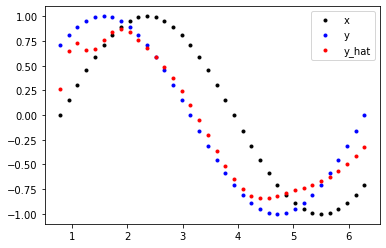

Step: 30/60, Loss: 0.0057


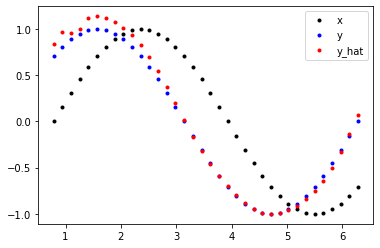

Step: 45/60, Loss: 0.0010


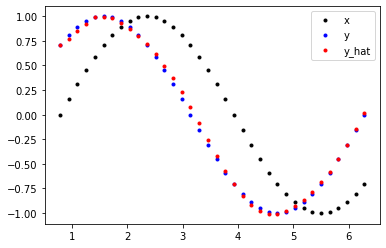

Step: 60/60, Loss: 0.0002


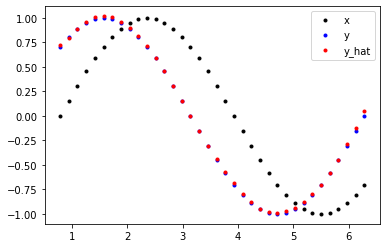

In [7]:
prediction = train(rnn_model, xtr, ytr, n_steps=60)